# Pumpkin Pricing
- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('US-pumpkins.csv')

pumpkins.head()

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [32]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month,
     'DayOfYear' : day_of_year,
     'Variety': pumpkins['Variety'],
     'City': pumpkins['City Name'],
     'Package': pumpkins['Package'],
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'],
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2


new_pumpkins.head()

C:\Users\KYLA\AppData\Local\Temp\ipykernel_12208\2542727883.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

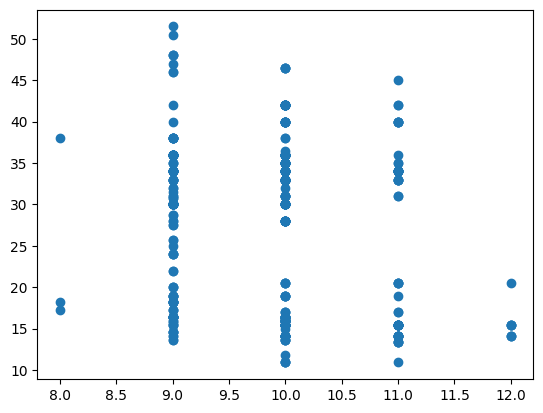

In [33]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

*It doesn't seem like there's much correlation.*

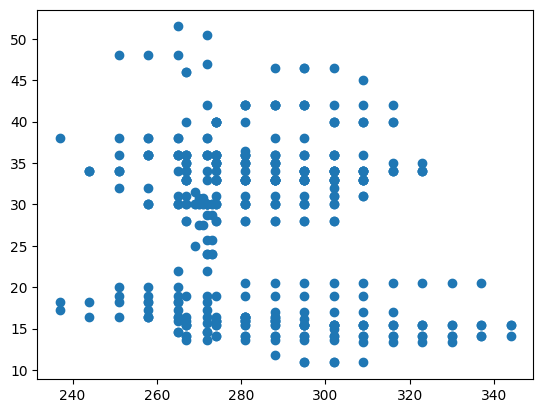

In [34]:
plt.scatter('DayOfYear','Price',data=new_pumpkins)

*It neither doesn't seem like there's much correlation.*

In [35]:
# Print the correlation between month and price
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))

# Print the correlation between Day of Year and price
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


The correlation for the two pairs of variables is close to 0, so any prediction we make with these isn't going to be super accurate.

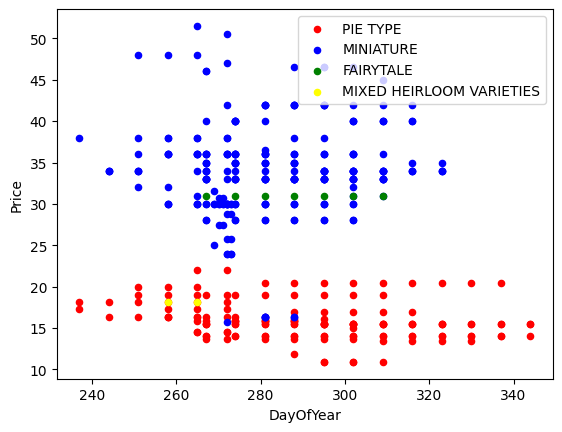

In [36]:
# Define the colors to use to plot the pumpkins
colors = ['red', 'blue', 'green', 'yellow']

# Plot the price vs day of year for the pumpkins, using a different color for each variety
ax = None
for i, var in enumerate(new_pumpkins['Variety'].unique()):
    variety = new_pumpkins[new_pumpkins['Variety'] == var]
    ax = variety.plot.scatter('DayOfYear', 'Price', color=colors[i], label=var, ax=ax)

<Axes: xlabel='Variety'>

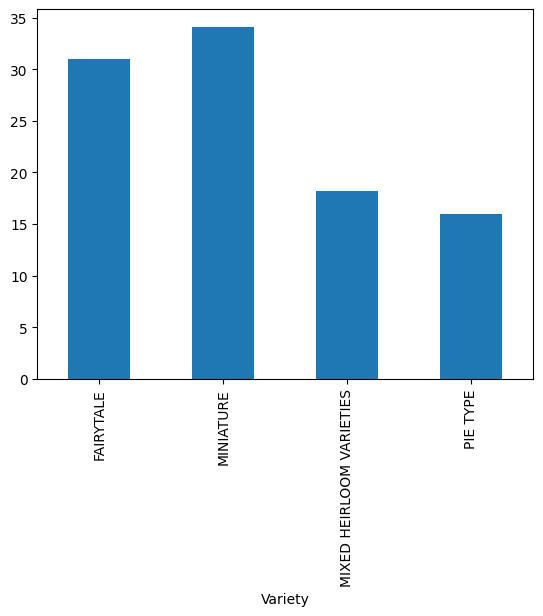

In [37]:
new_pumpkins.groupby(['Variety'])['Price'].mean().plot(kind='bar')

<Axes: xlabel='DayOfYear', ylabel='Price'>

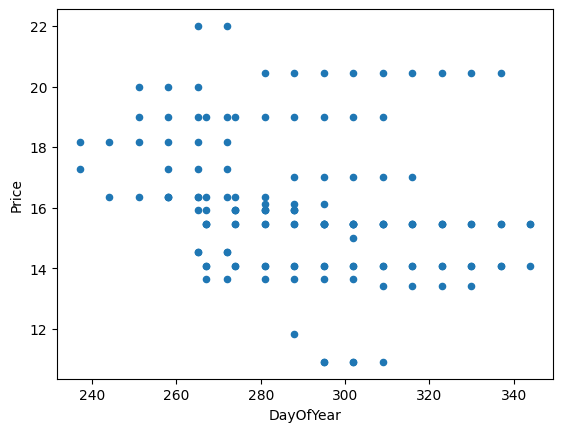

In [38]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety'] == 'PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear', 'Price')

In [39]:
# Print the correlation between month and price
print(pie_pumpkins['Month'].corr(pie_pumpkins['Price']))

# Print the correlation between Day of the year and price
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))

-0.23841413206125714
-0.2669192282197318


Before training a linear regression model, it is important to make sure that our data is clean. Linear regression does not work well with missing values, thus it makes sense to get rid of all empty cells:

In [40]:
pie_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 70 to 1630
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    int32  
 1   DayOfYear   144 non-null    int64  
 2   Variety     144 non-null    object 
 3   City        144 non-null    object 
 4   Package     144 non-null    object 
 5   Low Price   144 non-null    float64
 6   High Price  144 non-null    float64
 7   Price       144 non-null    float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 9.6+ KB


C:\Users\KYLA\AppData\Local\Temp\ipykernel_12208\3144308612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pie_pumpkins.dropna(inplace=True)


# Improving Pumpkin Price Predictions with Linear Regression using Scikit-learn

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [42]:
# Get the day of year and price in separate arrays
X = pie_pumpkins['DayOfYear'].values.reshape(-1, 1)
y = pie_pumpkins['Price']

# Print the shape
X.shape

(144, 1)

In [43]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [44]:
# Create a linear regression object
lin_reg = LinearRegression()

# Train the model with the training data
lin_reg.fit(X_train, y_train)

LinearRegression()

In [45]:
# Test the model using our test data
pred = lin_reg.predict(X_test)
pred

array([16.21096253, 16.73652536, 16.08833121, 15.35254325, 15.96569988,
       16.73652536, 16.21096253, 16.36863138, 16.61389403, 15.84306855,
       15.84306855, 15.72043723, 16.21096253, 15.5978059 , 16.45622519,
       15.72043723, 15.5978059 , 16.08833121, 15.72043723, 16.36863138,
       16.85915669, 16.21096253, 15.22991192, 16.21096253, 15.84306855,
       16.45622519, 16.08833121, 15.84306855, 15.5978059 ])

How good is this prediction?

In [46]:
# Calculate the mean squared error
mse = np.sqrt(mean_squared_error(y_test, pred))

# Print the mean squared error in an easy to read format
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.77 (17.2%)


This is a pretty big error so our predictions won't be great.

Another indicator of model quality is the coefficient of determination. This value can be anywhere between 0 and 1 and the closer to 1 it is, the better our model fits or the data.

In [47]:
# Calculate the coefficient of determination
score = lin_reg.score(X_train, y_train)
print('Model Determination: ', score)

Model Determination:  0.04460606335028361


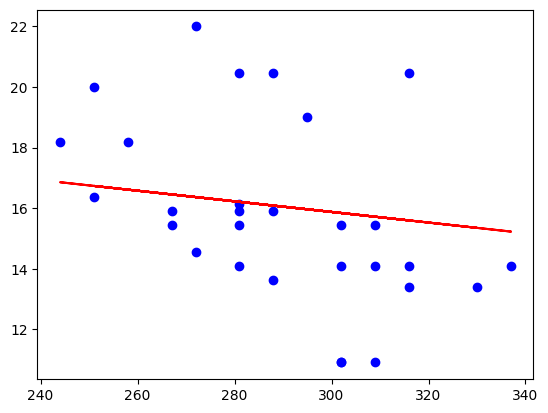

In [48]:
# Create a scatter plot using our test data
plt.scatter(X_test, y_test, color='blue')

# Add a line to the plot with the predictions
plt.plot(X_test, pred, color='red')

The graph we get is consistent with a numerical result. The vertical distance between the points and the prediction line does look pretty significant.

In [49]:
# Print the slope and the intercept
print(f"y = {lin_reg.coef_[0]}x + {lin_reg.intercept_}")

y = -0.017518760953105x + 21.133734359909326


Predict the price of a bushel of Pie Type pumpkins on 256th day of the year 

In [50]:
lin_reg.predict([[256]])

array([16.64893156])

Keep in mind that this prediction isn't super accurate because our mean squared error is so high.

# Improving Pumpkin Price Predictions with Polynomial Regression

Mean error: 2.73 (17.0%)


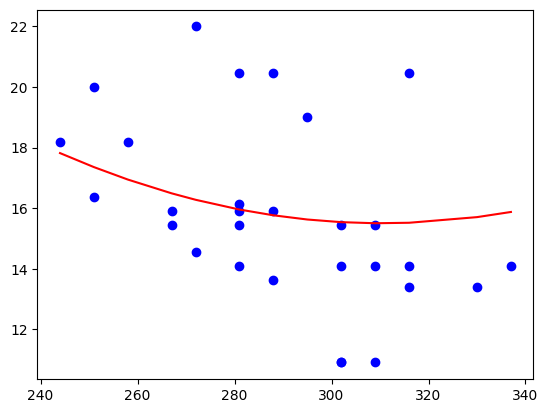

In [51]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Build a polynomial regression pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

# Use the pipeline to build the model
pipeline.fit(X_train, y_train)

# Test the model using our test data
pred = pipeline.predict(X_test)

# Calculate and print mean squared error
mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

# Plot the results
plt.scatter(X_test, y_test, color='blue')
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)), color='red')

In [52]:
# Score the model
score = pipeline.score(X_train, y_train)
print('Model Determination: ', score)

Model Determination:  0.07639977655280128


0.08 shows that we don't have a good fit but it's better than before.

Maybe we can add more features to our input X. If we add more information to our input X, we'll get better predictions in y. Let's start by adding the feature that encodes the pumpkin variety which is an important feature if we want to bring back the data for all Pumpkin types.

The original data set (pumpkin types) are encoded as strings, but regression expects the input data to be numerical. So we can't really use the data as it is.

Solution: Convert the pumpkin "variety" feature into a categorical feature.

In [53]:
# Convert the variety into a categorical feature
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [54]:
# Get the X value as a new data frame with the month column, along with the variety, city and package columns converted into a categorical feature
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))

# Get the Y value as the price
y = new_pumpkins['Price']

In [ ]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a linear regression object
lin_reg = LinearRegression()

# Train the model with the training data
lin_reg.fit(X_train, y_train)

# Test the model using our test data
pred = lin_reg.predict(X_test)

# Calculate the mean squared error
mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

# Calculate the coefficient of determination
score = lin_reg.score(X_train, y_train)
print('Model Determination: ', score)

Mean error: 2.84 (10.5%)
Model Determination:  0.9401401953107826


**Using Polynomial Regression**

In [56]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train, y_train)

# Predict results for test data
pred = pipeline.predict(X_test)

# Calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train, y_train)
print('Model Determination: ', score)

Mean error: 2.23 (8.28%)
Model Determination:  0.9653029999448537
